In [1]:
import numpy as np
import mass_balance as mb
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':'14'})
rc('text', usetex=False)

This notebook is based on OS16_final. 

Questions: 
- What happens when we use more recent exchange parameters? 
- What happens when we do dissolution? 

In [2]:
Tcmb = np.linspace(6000,3000,1001)
dT   = Tcmb[1]-Tcmb[0]

# Data taken from Extended Data Table 1 of O16 and my fit to B18 exchange data
a_Mg_D19_E, b_Mg_D19_E, c_Mg_D19_E = -3.00, -2314, 26.0   #                                (Exchange)
a_Mg_D19_E, b_Mg_D19_E, c_Mg_D19_E = -2.30, -2900, 16.0   #                                (Exchange) Fig 3
a_Mg_B18_E, b_Mg_B18_E, c_Mg_B18_E = -1.45, -3600, 0.0    #                                (Exchange)
a_Mg_O16_E, b_Mg_O16_E, c_Mg_O16_E = 0.1 ,-10851,0.0  # OS16                               (Exchange)
a_Mg_B18_Ds, b_Mg_B18_Ds, c_Mg_B18_Ds = -1.04, -6151, 0.0 #                                (Dissociation)
Kd_Mg_O16_E  = 10**mb.logKd(a_Mg_O16_E , b_Mg_O16_E , c_Mg_O16_E , Tcmb)
Kd_Mg_B18_E  = 10**mb.logKd(a_Mg_B18_E , b_Mg_B18_E , c_Mg_B18_E , Tcmb)
Kd_Mg_D19_E  = 10**mb.logKd(a_Mg_D19_E , b_Mg_D19_E , c_Mg_D19_E , Tcmb)
Kd_Mg_B18_Ds = 10**mb.logKd(a_Mg_B18_Ds, b_Mg_B18_Ds, c_Mg_B18_Ds, Tcmb)

a_Si_O16, b_Si_O16, c_Si_O16 = 1.3 ,-13500,0.0  # Originally from Fischer et al 2015 (Exchange)
a_O_O16 , b_O_O16 , c_O_O16  = 0.6 ,-3800 ,22.0 # Originally from Fischer et al 2015 (Dissolution)
a_O_M20 , b_O_M20 , c_O_M20  =-0.3 , 0.0  ,-36.8
Kd_O         = 10**mb.logKd(a_O_O16 , b_O_O16 , c_O_O16 , Tcmb) 
Kd_O_M20     = 10**mb.logKd(a_O_M20 , b_O_M20 , c_O_M20 , Tcmb) 
Kd_Si        = 10**mb.logKd(a_Si_O16, b_Si_O16, c_Si_O16, Tcmb) 
Kd_Si_Ds     = 2*Kd_Si * (Kd_O_M20)**2

# O16 0.25 sigms soln
fac = 0.25
a_O_O16_25s , b_O_O16_25s , c_O_O16_25s  = (a_O_O16-fac*0.4), (b_O_O16+fac*900) , (c_O_O16-fac*14) 

Kd_Mg_25s = 10**mb.logKd(a_Mg_O16_E , b_Mg_O16_E , c_Mg_O16_E , Tcmb)   
Kd_O_25s  = 10**mb.logKd(a_O_O16_25s, b_O_O16_25s, c_O_O16_25s, Tcmb) 
Kd_Si_25s = 10**mb.logKd(a_Si_O16   , b_Si_O16   , c_Si_O16   , Tcmb) 

verbose = 2
var     = 1

print(-3.00 -10*np.log10(1-0.1),-3.00 -10*np.log10(1-0.15), -3.00 -10*np.log10(1-0.07))

-2.542425094393249 -2.294189257142927 -2.6848294855393506


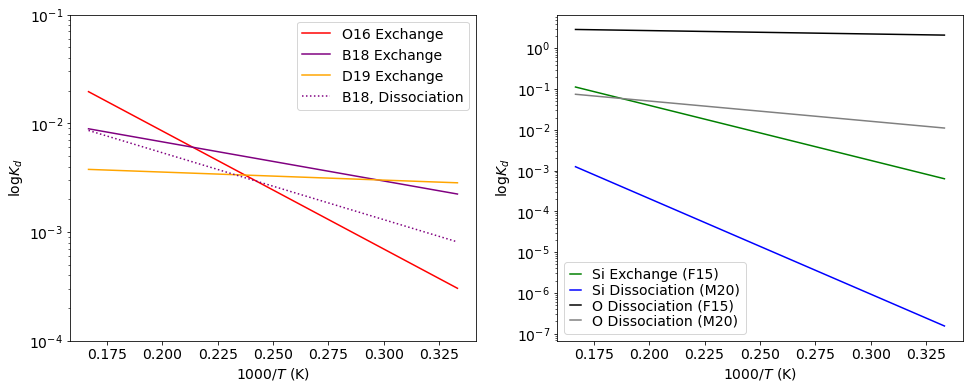

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.set_xlabel("$1000/T$ (K)")
ax1.set_ylabel("$\log K_d$")
ax1.set_yscale('log')
ax1.set_ylim([1e-4, 1e-1])
ax1.plot(1000/Tcmb, Kd_Mg_O16_E, label="O16 Exchange", color="red")
ax1.plot(1000/Tcmb, Kd_Mg_B18_E, label="B18 Exchange", color="purple")
ax1.plot(1000/Tcmb, Kd_Mg_D19_E, label="D19 Exchange", color="orange")
ax1.plot(1000/Tcmb, Kd_Mg_B18_Ds, label="B18, Dissociation", color="purple", ls=':')
ax1.legend()

ax2.set_xlabel("$1000/T$ (K)")
ax2.set_ylabel("$\log K_d$")
ax2.set_yscale('log')
ax2.plot(1000/Tcmb, Kd_Si    , label="Si Exchange (F15)", color="green")
ax2.plot(1000/Tcmb, Kd_Si_Ds , label="Si Dissociation (M20)", color="blue")
ax2.plot(1000/Tcmb, Kd_O     , label="O Dissociation (F15)" , color="black")
ax2.plot(1000/Tcmb, Kd_O_M20 , label="O Dissociation (M20)" , color="grey")
ax2.legend( labelspacing=0.1,handlelength=0.8 )
fig.savefig("var_Kd.pdf", format='pdf',bbox_inches="tight")

### Compare O16, B18 and D19 solutions

In [4]:
iMFe, iMO, iMSi, iMMg = 79, 19, 5, 4 # Default composition
iMFeO, iMMgO, iMSiO2  = 22, 50, 6
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
O16_E     = mb.run_massbalance(iM, [Kd_Mg_O16_E, Kd_O, Kd_Si], Tcmb, 1, verbose)
B18_E     = mb.run_massbalance(iM, [Kd_Mg_B18_E, Kd_O, Kd_Si], Tcmb, 1, verbose)
D19_E     = mb.run_massbalance(iM, [Kd_Mg_D19_E, Kd_O, Kd_Si], Tcmb, 1, verbose)
O16_E_25s = mb.run_massbalance(iM, [Kd_Mg_25s, Kd_O_25s, Kd_Si_25s], Tcmb, 1, verbose)

if verbose == 1:
    mb.print_init_conc(O16_E[0],O16_E[2])
    mb.print_any_conc(O16_E[1],O16_E[3],-1)
    mb.plot_paper(Tcmb, O16_E[5], O16_E[1], O16_E[3], O16_E[4])
    mb.plot_paper(Tcmb, B18_E[5], B18_E[1], B18_E[3], B18_E[4])
    mb.plot_paper(Tcmb, D19_E[5], D19_E[1], D19_E[3], D19_E[4])

MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange


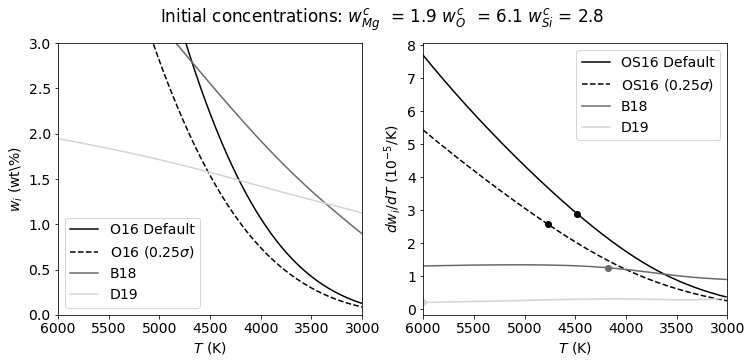

In [22]:
fig, ((ax3, ax5)) = plt.subplots(1, 2, figsize=(12,5))

# wt% Mg (element 3)
ax3.set_xlim([np.max(Tcmb),np.min(Tcmb)])
ax3.set_ylim([0,3])       # To compare to the Du plot. 
ax3.set_xlabel("$T$ (K)")
ax3.set_ylabel("$w_{i}$ (wt\%)")
ax3.plot(Tcmb, O16_E[3][3]*100    , color='black'    , label="O16 Default")
ax3.plot(Tcmb, O16_E_25s[3][3]*100, color='black'    , label="O16 ($0.25\sigma$)", ls='--')
ax3.plot(Tcmb, B18_E[3][3]*100    , color='dimgrey'  , label="B18")
ax3.plot(Tcmb, D19_E[3][3]*100    , color='lightgrey', label="D19")
ax3.legend()

dcdT_O16_25s = np.gradient(O16_E_25s[3][3], dT)*1e5
dcdT_O16     = np.gradient(O16_E[3][3], dT)*1e5
dcdT_B18     = np.gradient(B18_E[3][3], dT)*1e5
dcdT_D19     = np.gradient(D19_E[3][3], dT)*1e5

# change in MgO conc (element 5)
fig.suptitle("Initial concentrations: $w_{Mg}^c$  = "+str(np.round(O16_E[2][3]*100,1)) + 
                 " $w_{O}^c$  = "+str(np.round(O16_E[2][1]*100,1)) + 
                 " $w_{Si}^c$ = "+str(np.round(O16_E[2][2]*100,1)))
ax5.set_xlim([np.max(Tcmb),np.min(Tcmb)])
ax5.set_xlabel("$T$ (K)")
ax5.set_ylabel("$d w_{i}/dT$ ($10^{-5}$/K)")
ax5.plot(Tcmb, dcdT_O16    , color='black'    , label="OS16 Default"       , linestyle='-')
ax5.plot(Tcmb, dcdT_O16_25s, color='black'    , label="OS16 ($0.25\sigma$)", linestyle='--')
ax5.plot(Tcmb, dcdT_B18    , color='dimgrey'  , label="B18"                , linestyle='-')
ax5.plot(Tcmb, dcdT_D19    , color='lightgrey', label="D19"                , linestyle='-')
ax5.plot(Tcmb[O16_E[4][2]]    , dcdT_O16[O16_E[4][2]]        , color='black'    , marker='o')
ax5.plot(Tcmb[O16_E_25s[4][2]], dcdT_O16_25s[O16_E_25s[4][2]], color='black'    , marker='o')
ax5.plot(Tcmb[B18_E[4][2]]    , dcdT_B18[B18_E[4][2]]        , color='dimgrey'  , marker='o')
ax5.plot(Tcmb[D19_E[4][2]]    , dcdT_D19[D19_E[4][2]]        , color='lightgrey', marker='o')
ax5.legend()
fig.savefig("var_compMg.pdf", format='pdf',bbox_inches="tight")

### Solution at the conditions of B18 Fig 3a: 
- 3 wt% O, 3 wt % Si and 0 Mg in the core
- 50 mol% MgO

MgO Exchange
Initial core mole fractions of Fe  =   0.84 O   =   0.10 Si   =   0.06 Mg  =   0.00 All =   1.00
Initial mant mole fractions of FeO =   0.30 MgO =   0.50 SiO2 =   0.20 all =   1.00
Initial core mass fractions of O   =   3.14 Mg  =   0.00 Si  =   3.30
Initial mant mass fractions of FeO =  40.30 MgO =  37.31 SiO2 =  22.39
Core mole fractions of Fe  =   0.76 O   =   0.21 Si   =   0.02 Mg  =   0.01 All =   1.00
Mant mole fractions of FeO =   0.07 MgO =   0.62 SiO2 =   0.30 all =   1.00
Core mass fractions of O   =   7.12 Mg  =   0.73 Si  =   1.17
Mant mass fractions of FeO =  11.13 MgO =  51.52 SiO2 =  37.36


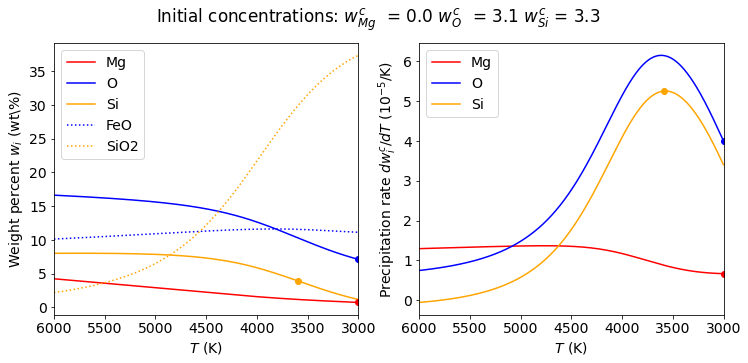

In [16]:
iMFe, iMO, iMSi, iMMg = 85, 10, 6, 0 # Zero Mg as in D19 Fig 3
iMFeO, iMMgO, iMSiO2  = 30, 50, 20
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
B18_E_Fig3 = mb.run_massbalance(iM, [Kd_Mg_B18_E, Kd_O, Kd_Si], Tcmb, 1, verbose)

mb.print_init_conc(B18_E_Fig3[0],B18_E_Fig3[2])
mb.print_any_conc(B18_E_Fig3[1],B18_E_Fig3[3],-1)
fig, ax1, ax2 = mb.plot_paper(Tcmb, B18_E_Fig3[5], B18_E_Fig3[1], B18_E_Fig3[3], B18_E_Fig3[4])

fig.suptitle("Initial concentrations: $w_{Mg}^c$  = "+str(np.round(B18_E_Fig3[2][3]*100,1)) + 
                 " $w_{O}^c$  = "+str(np.round(B18_E_Fig3[2][1]*100,1)) + 
                 " $w_{Si}^c$ = "+str(np.round(B18_E_Fig3[2][2]*100,1)))
fig.savefig("var_b18.pdf", format='pdf',bbox_inches="tight")

### Iterate over core compositions for B18 solution above

MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:title={'center':'$w_{FeO}^m$ = 40.3, $w_{MgO}^m$   = 37.3, $w_{SiO_2}^c$ = 22.4'}, xlabel='$T$ (K)', ylabel='$d w_{Mg}^c/dT$ ($10^{-5}$ K$^{-1}$)'>)

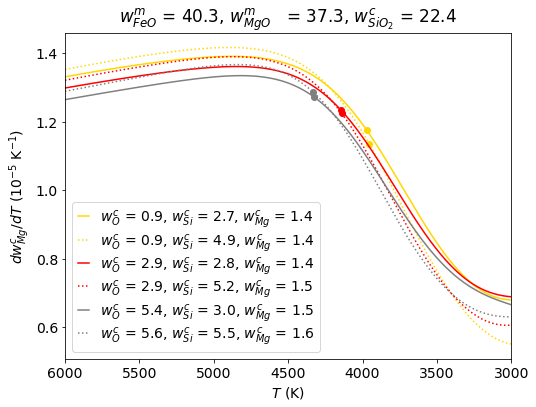

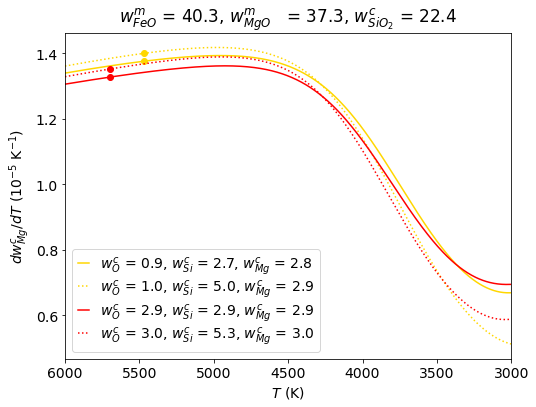

In [35]:
def core_var(NMg, Tcmb, NO_array, NSi_array):

    fig, ax = plt.subplots(figsize=(8,6))

    dT   = Tcmb[1] - Tcmb[0]

    iMFeO, iMMgO, iMSiO2  = 30, 50, 20
    Ntot = 100 

    ls = ["-", ":"] 
    lc = ["gold", "red", "grey"] 

    for NOi, NO in enumerate(NO_array):
        for NSii, NSi in enumerate(NSi_array):

            iMFe, iMO, iMSi, iMMg = Ntot-NO-NSi-NMg, NO, NSi, NMg 
            iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
            B18_E_cvar = mb.run_massbalance(iM, [Kd_Mg_B18_E, Kd_O, Kd_Si], Tcmb, 1, verbose)

            if verbose == 1:
                mb.print_init_conc(B18_E_cvar[0],B18_E_cvar[2])

            dcMgdT_cvar = np.gradient(B18_E_cvar[3][3], dT)*1e5
            ax.plot(Tcmb, dcMgdT_cvar, label="$w_O^c$ = "+str(np.round(B18_E_cvar[2][1]*100,1))
                    +", $w_{Si}^c$ = "+str(np.round(B18_E_cvar[2][2]*100,1))
                    +", $w_{Mg}^c$ = "+str(np.round(B18_E_cvar[2][3]*100,1)), 
                    color=lc[NOi], linestyle=ls[NSii])
            ax.plot(Tcmb[B18_E_cvar[4][2]], dcMgdT_cvar[B18_E_cvar[4][2]], color=lc[NOi], marker='o')
    
    ax.set_xlim([np.max(Tcmb),np.min(Tcmb)])
    ax.set_xlabel("$T$ (K)")
    ax.set_ylabel("$d w_{Mg}^c/dT$ ($10^{-5}$ K$^{-1}$)")
    ax.set_title("$w_{FeO}^m$ = "+str(np.round(B18_E_cvar[2][4]*100,1))
            +", $w_{MgO}^m$   = "+str(np.round(B18_E_cvar[2][5]*100,1))
            +", $w_{SiO_2}^c$ = "+str(np.round(B18_E_cvar[2][6]*100,1)))
    ax.legend(ncol=1, labelspacing=0.1,handlelength=0.8, columnspacing=0.5)
    
    fig.savefig("var_b18_coreconc_NMg="+str(NMg)+".pdf", format='pdf',bbox_inches="tight")
    
    return fig, ax

NSi_array = [5, 9]

NO_array  = [3, 9, 16]
core_var(3, Tcmb, NO_array, NSi_array)

NO_array  = [3, 9]
core_var(6, Tcmb, NO_array, NSi_array)

### Effect of oxide composition on the B18 Exchange and Dissociation solns

In [25]:
def ox_var(var, Kd_array, Tcmb): 
    
    dT   = Tcmb[1]-Tcmb[0]

    iMFe, iMO, iMSi, iMMg = 79, 19, 5, 4 # Default composition
    iMFeO, iMMgO, iMSiO2  = 22, 50, 6
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_def    = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)
    
    iMFe, iMO, iMSi, iMMg = 79, 19, 5, 4 # High SiO2
    iMFeO, iMMgO, iMSiO2  = 28, 40, 50
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_highS  = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)

    if verbose == 1:
        mb.print_init_conc(B18_E_m_def[0],B18_E_m_def[2])
        mb.print_init_conc(B18_E_m_highS[0],B18_E_m_highS[2])
    
    iMFe, iMO, iMSi, iMMg = 79, 19, 5, 6 # High SiO2
    iMFeO, iMMgO, iMSiO2  = 28, 40, 50
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_highSa = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)

    iMFe, iMO, iMSi, iMMg = 79, 19, 5, 4 # High FeO
    iMFeO, iMMgO, iMSiO2  = 48, 50, 20
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_highF  = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)

    iMFe, iMO, iMSi, iMMg = 79, 19, 5, 6 # High FeO
    iMFeO, iMMgO, iMSiO2  = 48, 50, 20
    iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
    B18_E_m_highFa = mb.run_massbalance(iM, Kd_array, Tcmb, var, verbose)
            
    dcMgdT_m_def   = np.gradient(B18_E_m_def[3][3], dT)*1e5
    dcMgdT_m_highS = np.gradient(B18_E_m_highS[3][3], dT)*1e5
    dcMgdT_m_highF = np.gradient(B18_E_m_highF[3][3], dT)*1e5
    dcMgdT_m_highSa= np.gradient(B18_E_m_highSa[3][3], dT)*1e5
    dcMgdT_m_highFa= np.gradient(B18_E_m_highFa[3][3], dT)*1e5

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))

    ax1.set_xlim([np.max(Tcmb),np.min(Tcmb)])
    ax1.set_xlabel("$T$ (K)")
    ax1.set_ylabel("$d w_{MgO}^c/dT$ ($10^{-5}$ K$^{-1}$)")
    ax1.plot(Tcmb, dcMgdT_m_def  , label="$w_{FeO}^m$ = "+str(np.round(B18_E_m_def[2][4]*100,1))
            +", $w_{MgO}^m$ = "+str(np.round(B18_E_m_def[2][5]*100,1))
            +", $w_{Mg}^c$  = "+str(np.round(B18_E_m_def[2][3]*100,1)), color="red")

    ax1.plot(Tcmb, dcMgdT_m_highS, label="$w_{FeO}^m$ = "+str(np.round(B18_E_m_highS[2][4]*100,1))
            +", $w_{MgO}^m$ = "+str(np.round(B18_E_m_highS[2][5]*100,1))
            +", $w_{Mg}^c$  = "+str(np.round(B18_E_m_highS[2][3]*100,1)), color="purple")

    ax1.plot(Tcmb, dcMgdT_m_highSa, label="$w_{FeO}^m$ = "+str(np.round(B18_E_m_highSa[2][4]*100,1))
            +", $w_{MgO}^m$ = "+str(np.round(B18_E_m_highSa[2][5]*100,1))
            +", $w_{Mg}^c$  = "+str(np.round(B18_E_m_highSa[2][3]*100,1)), color="purple", ls=':')

    ax1.plot(Tcmb, dcMgdT_m_highF, label="$w_{FeO}^m$ = "+str(np.round(B18_E_m_highF[2][4]*100,1))
            +", $w_{MgO}^m$ = "+str(np.round(B18_E_m_highF[2][5]*100,1))
            +", $w_{Mg}^c$  = "+str(np.round(B18_E_m_highF[2][3]*100,1)), color="blue")
    
    ax1.plot(Tcmb, dcMgdT_m_highFa, label="$w_{FeO}^m$ = "+str(np.round(B18_E_m_highFa[2][4]*100,1))
            +", $w_{MgO}^m$ = "+str(np.round(B18_E_m_highFa[2][5]*100,1))
            +", $w_{Mg}^c$  = "+str(np.round(B18_E_m_highFa[2][3]*100,1)), color="blue", ls=':')
    
    ax1.plot(Tcmb[B18_E_m_def[4][2]]   , dcMgdT_m_def[B18_E_m_def[4][2]]      , marker='o', color="red")
    ax1.plot(Tcmb[B18_E_m_highS[4][2]] , dcMgdT_m_highS[B18_E_m_highS[4][2]]  , marker='o', color="purple")
    ax1.plot(Tcmb[B18_E_m_highSa[4][2]], dcMgdT_m_highSa[B18_E_m_highSa[4][2]], marker='*', color="purple")
    ax1.plot(Tcmb[B18_E_m_highF[4][2]] , dcMgdT_m_highF[B18_E_m_highF[4][2]]  , marker='o', color="blue")
    ax1.plot(Tcmb[B18_E_m_highFa[4][2]], dcMgdT_m_highFa[B18_E_m_highFa[4][2]], marker='*', color="blue")
    ax1.legend(ncol=1, labelspacing=0.1,handlelength=0.8, columnspacing=0.5)
    
    fig.suptitle("Initial concentrations: $w_{O}^c$  = "+str(np.round(B18_E_m_def[2][1]*100,1)) + 
                 " $w_{Si}^c$ = "+str(np.round(B18_E_m_def[2][2]*100,1)))
    ax2.set_xlim([np.max(Tcmb),np.min(Tcmb)])
    ax2.set_xlabel("$T$ (K)")
    ax2.set_ylabel("Weight percent $w_{i}$ (wt\%)")
    ax2.plot(Tcmb, B18_E_m_def[3][3]*100  , color='red')
    ax2.plot(Tcmb, B18_E_m_highS[3][3]*100, color='purple')
    ax2.plot(Tcmb, B18_E_m_highF[3][3]*100, color='blue')   
    ax2.plot(Tcmb, B18_E_m_def[3][2]*100  , color='red'   , ls='--')
    ax2.plot(Tcmb, B18_E_m_highS[3][2]*100, color='purple', ls='--')
    ax2.plot(Tcmb, B18_E_m_highF[3][2]*100, color='blue'  , ls='--')  
    ax2.plot(Tcmb[B18_E_m_def[4][2]]  , B18_E_m_def[3][3][B18_E_m_def[4][2]]*100    , marker='o', color="red")
    ax2.plot(Tcmb[B18_E_m_highS[4][2]], B18_E_m_highS[3][3][B18_E_m_highS[4][2]]*100, marker='o', color="purple")
    ax2.plot(Tcmb[B18_E_m_highF[4][2]], B18_E_m_highF[3][3][B18_E_m_highF[4][2]]*100, marker='o', color="blue")
    ax2.plot(Tcmb[B18_E_m_def[4][1]]  , B18_E_m_def[3][2][B18_E_m_def[4][1]]*100    , marker='*', color="red")
    ax2.plot(Tcmb[B18_E_m_highS[4][1]], B18_E_m_highS[3][2][B18_E_m_highS[4][1]]*100, marker='*', color="purple")
    ax2.plot(Tcmb[B18_E_m_highF[4][1]], B18_E_m_highF[3][2][B18_E_m_highF[4][1]]*100, marker='*', color="blue")
    
    fig.savefig("var_mantleconc_reaction="+str(var)+".pdf", format='pdf',bbox_inches="tight")
    return

MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange
MgO Exchange


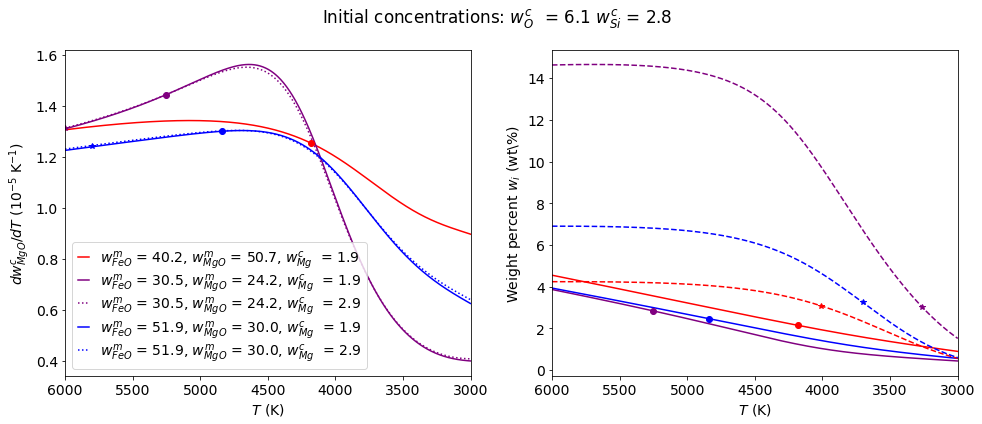

In [26]:
ox_var(1, [Kd_Mg_B18_E , Kd_O, Kd_Si], Tcmb)

MgO Dissolution
MgO Dissolution
MgO Dissolution
MgO Dissolution
MgO Dissolution


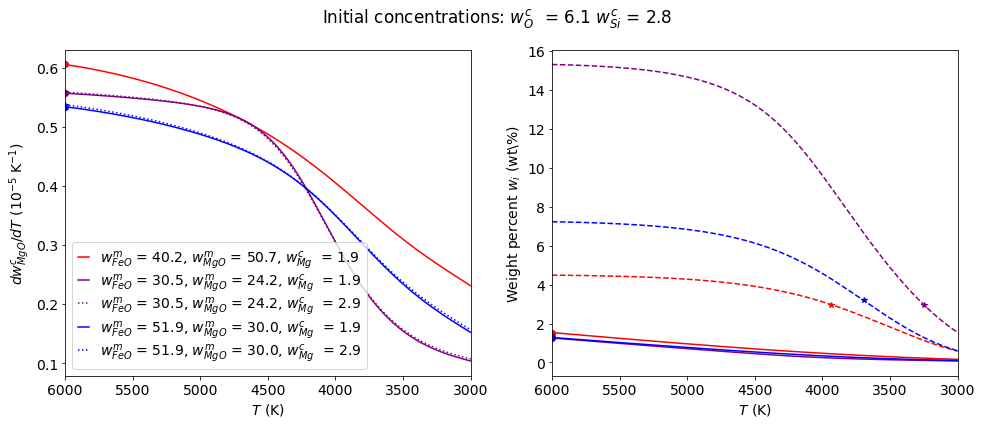

In [27]:
ox_var(3, [Kd_Mg_B18_Ds, Kd_O, Kd_Si], Tcmb)

MgO and SiO2 Dissolution
MgO and SiO2 Dissolution
MgO and SiO2 Dissolution
MgO and SiO2 Dissolution
MgO and SiO2 Dissolution


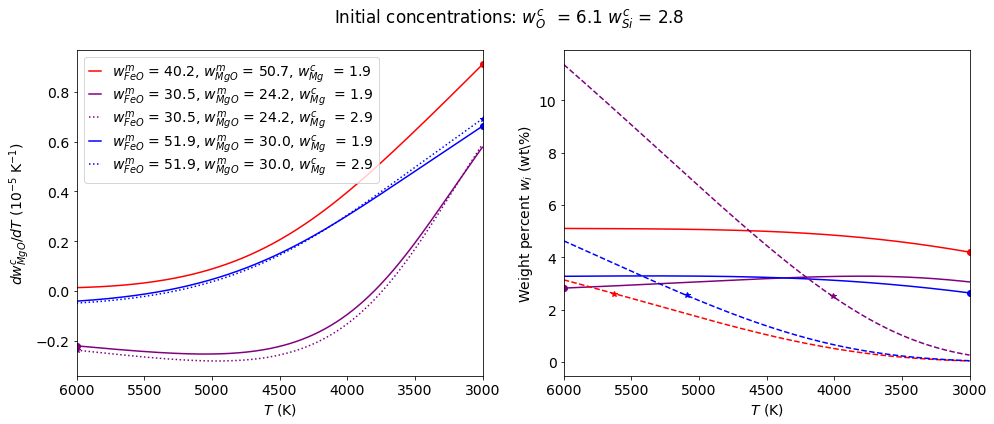

In [28]:
ox_var(2, [Kd_Mg_B18_Ds, Kd_O_M20, Kd_Si_Ds], Tcmb)

MgO Exchange


(<Figure size 864x360 with 2 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='Weight percent $w_{i}$ (wt\\%)'>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='Precipitation rate $d w_{i}^c/dT$ ($10^{-5}$/K)'>)

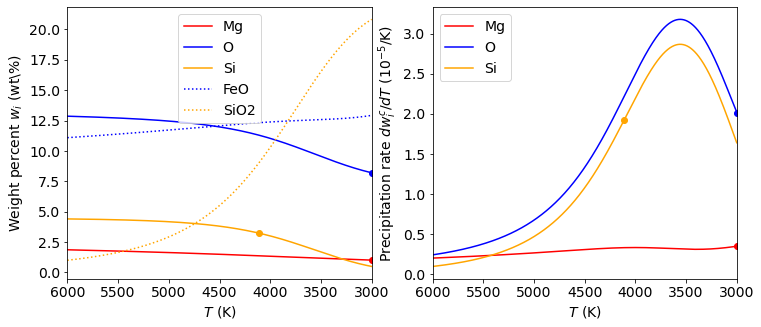

In [12]:
iMFe, iMO, iMSi, iMMg = 79, 19, 5, 0 # Zero Mg as in D19 Fig 3
iMFeO, iMMgO, iMSiO2  = 22, 50, 6
iM = [iMFe, iMO, iMSi, iMMg, iMFeO, iMMgO, iMSiO2]
D19_Fig3 = mb.run_massbalance(iM, [Kd_Mg_D19_E, Kd_O, Kd_Si], Tcmb, 1, verbose)
mb.plot_paper(Tcmb, D19_Fig3[5], D19_Fig3[1], D19_Fig3[3], D19_Fig3[4])